In [1]:
# Procesamiento de datos
import pandas as pd
import numpy as np
import re

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y modelado clásico
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# Deep Learning con Keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout

# Transformers y Deep Learning con PyTorch
import torch
from transformers import DistilBertTokenizer, DistilBertModel

# Barra de progreso
from tqdm import tqdm

C:\Users\sebas\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(fr'noticias_limpias_balanceadas2.csv')
df_diccionario = pd.read_csv(fr'diccionario.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   titulo     6800 non-null   object
 1   autor      6800 non-null   object
 2   fecha      6800 non-null   object
 3   contenido  6800 non-null   object
 4   label      6800 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 265.8+ KB


In [4]:
df_metadata = df.copy()
df_heuristica = df.copy()

Reglas Heuristicas

In [6]:
def construir_diccionario_emocional(df_diccionario):
    emociones = df_diccionario.columns[1:]  # Todas menos 'palabra'
    diccionario_emocional = {}
    for _, fila in df_diccionario.iterrows():
        palabra = fila['palabra']
        emociones_asociadas = [emocion for emocion in emociones if fila[emocion] == 1]
        if emociones_asociadas:
            diccionario_emocional[palabra] = emociones_asociadas
    return diccionario_emocional

def calcular_emotividad(texto, diccionario):
    palabras = re.findall(r'\b\w+\b', str(texto).lower())
    total = len(palabras)
    emocionales = sum(1 for palabra in palabras if palabra in diccionario)
    return emocionales / total if total > 0 else 0

def emocion_predominante(texto, diccionario):
    palabras = re.findall(r'\b\w+\b', str(texto).lower())
    emociones = []
    for palabra in palabras:
        if palabra in diccionario:
            emociones.extend(diccionario[palabra])
    if emociones:
        return Counter(emociones).most_common(1)[0][0]
    else:
        return 'ninguna'

def aplicar_emotividad(df_heuristica, df_diccionario):
    diccionario_emocional = construir_diccionario_emocional(df_diccionario)
    df_heuristica['score_emotividad'] = df_heuristica['contenido'].apply(
        lambda x: calcular_emotividad(x, diccionario_emocional)
    )
    df_heuristica['emocion_predominante'] = df_heuristica['contenido'].apply(
        lambda x: emocion_predominante(x, diccionario_emocional)
    )
    return df_heuristica[['score_emotividad']]

In [13]:
!pip install nltk


  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)


In [14]:
import string
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

verbos_modales = ['debería', 'podría', 'tendría', 'habría', 'puede', 'pueden', 'podría', 'debe', 'deben', 'sería']
terminos_generalizadores = ['siempre', 'nunca', 'todos', 'nadie', 'jamás', 'ninguno', 'cualquiera']
verbos_opinion = ['creo', 'considero', 'opino', 'pienso', 'me parece', 'supongo', 'siento', 'estimo']
lexico_polarizado = ['horrible', 'excelente', 'terrible', 'maravilloso', 'desastroso', 'perfecto', 'abominable', 'magnífico']

def limpiar_texto_heuristica(texto):
    if not isinstance(texto, str):
        return ""
    texto = texto.lower()
    for c in string.punctuation:
        texto = texto.replace(c, "")
    return texto

def frecuencia_heuristica(texto, palabras_clave):
    texto_limpio = limpiar_texto_heuristica(texto)
    palabras = texto_limpio.split()
    return sum(1 for palabra in palabras if palabra in palabras_clave)

def diversidad_lexica(texto):
    texto_limpio = limpiar_texto_heuristica(texto)
    palabras = [p for p in texto_limpio.split() if p.isalpha() and p not in stop_words]
    if len(palabras) == 0:
        return 0
    return len(set(palabras)) / len(palabras)

def aplicar_heuristicas_linguisticas(df_heuristica):
    df_heuristica['incertidumbre'] = df_heuristica['contenido'].apply(
        lambda x: frecuencia_heuristica(x, verbos_modales + terminos_generalizadores)
    )
    df_heuristica['subjetividad'] = df_heuristica['contenido'].apply(
        lambda x: frecuencia_heuristica(x, verbos_opinion + lexico_polarizado)
    )
    df_heuristica['diversidad_lexica'] = df_heuristica['contenido'].apply(diversidad_lexica)
    return df_heuristica[['incertidumbre', 'subjetividad', 'diversidad_lexica']]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
!python -m spacy download es_core_news_sm


     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     ------ --------------------------------- 2.1/12.9 MB 11.8 MB/s eta 0:00:01
     ------------- -------------------------- 4.5/12.9 MB 11.7 MB/s eta 0:00:01
     --------------------- ------------------ 6.8/12.9 MB 11.7 MB/s eta 0:00:01
     ----------------------------- ---------- 9.4/12.9 MB 11.7 MB/s eta 0:00:01
     ---------------------------------- ---- 11.5/12.9 MB 11.8 MB/s eta 0:00:01
     --------------------------------------- 12.9/12.9 MB 11.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [16]:
!pip install spacy

  Using cached spacy-3.8.7-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.13-cp312-cp312-win_amd64.whl.metadata (2.2 kB)
  Using cached cymem-2.0.11-cp312-cp312-win_amd64.whl.metadata (8.8 kB)
  Using cached preshed-3.0.10-cp312-cp312-win_amd64.whl.metadata (2.5 kB)
  Using cached thinc-8.3.6-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.5.1-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached typer-0.16.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl.metadata (29 kB)
  Using cached language_data-1.3.0-py3-no

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.3.1 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.1 which is incompatible.


In [19]:
import spacy
nlp = spacy.load("es_core_news_sm", disable=["ner", "tagger"])

def aplicar_patrones_sintacticos(df_heuristica):
    resultados = []
    for doc in nlp.pipe(df_heuristica['contenido'], batch_size=32):
        oraciones = list(doc.sents)
        total_palabras = len([token.text for token in doc if token.is_alpha])
        total_palabras_mayus = len([token.text for token in doc if token.is_upper])
        total_exclamaciones = doc.text.count('!')
        frases_cortas = sum(1 for s in oraciones if len(s.text.split()) <= 7)
        porcentaje_mayus = total_palabras_mayus / total_palabras if total_palabras > 0 else 0
        frases_cortas_porcentaje = frases_cortas / len(oraciones) if oraciones else 0
        resultados.append({
            "porcentaje_mayusculas": porcentaje_mayus,
            "exclamaciones_totales": total_exclamaciones,
            "frases_cortas": frases_cortas,
            "frases_cortas_%": frases_cortas_porcentaje
        })
    df_patrones = pd.DataFrame(resultados, index=df_heuristica.index)
    return df_patrones

In [20]:
import string
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

def limpiar_texto_jaccard(texto):
    if not isinstance(texto, str):
        return ""
    texto = texto.lower()
    for c in string.punctuation:
        texto = texto.replace(c, "")
    return texto

def consistencia_jaccard(titulo, contenido):
    titulo = limpiar_texto_jaccard(titulo)
    contenido = limpiar_texto_jaccard(contenido)
    set_titulo = set([p for p in titulo.split() if p not in stop_words])
    set_contenido = set([p for p in contenido.split() if p not in stop_words])
    if len(set_titulo) == 0 or len(set_contenido) == 0:
        return 0
    interseccion = set_titulo.intersection(set_contenido)
    union = set_titulo.union(set_contenido)
    return len(interseccion) / len(union)

def aplicar_relacion_titulo_cuerpo(df_heuristica):
    df_heuristica['consistencia_titulo_cuerpo'] = df_heuristica.apply(
        lambda row: consistencia_jaccard(row['titulo'], row['contenido']), axis=1)
    return df_heuristica[['consistencia_titulo_cuerpo']]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def generar_embedding_heuristico(df, df_diccionario):
    emotividad = aplicar_emotividad(df.copy(), df_diccionario)
    heuristicas = aplicar_heuristicas_linguisticas(df.copy())
    patrones = aplicar_patrones_sintacticos(df.copy())
    relacion = aplicar_relacion_titulo_cuerpo(df.copy())

    heuristico_df = pd.concat([emotividad, heuristicas, patrones, relacion], axis=1)
    heuristico_df = heuristico_df.replace([np.inf, -np.inf], np.nan).fillna(0)
    return heuristico_df.to_numpy()

#Feature Engineering

In [22]:
def feature_engineering(df):
    df['longitud'] = df['contenido'].apply(lambda x: len(str(x).split()))
    df['longitud_titulo'] = df['titulo'].apply(lambda x: len(str(x).split()))
    df['exclamaciones'] = df['contenido'].apply(lambda x: str(x).count('!'))
    df['interrogaciones'] = df['contenido'].apply(lambda x: str(x).count('?'))
    sensacionalistas = ['increíble', 'urgente', 'impactante', 'viral', 'escándalo']
    df['palabras_sensacionalistas'] = df['contenido'].apply(lambda x: sum(x.lower().count(p) for p in sensacionalistas))
    df['fecha'] = pd.to_datetime(df['fecha'], format='%d-%m-%Y', errors='coerce')
    df['dia_semana'] = df['fecha'].dt.day_name()
    df['mes'] = df['fecha'].dt.month
    df['noticias_autor'] = df['autor'].map(df['autor'].value_counts())
    df['relacion_titulo_contenido'] = df.apply(lambda r: r['longitud_titulo'] / r['longitud'] if r['longitud'] > 0 else 0, axis=1)
    autor_freq = df['autor'].value_counts()
    df['autor'] = df['autor'].apply(lambda x: x if x in autor_freq[autor_freq > 20].index else 'Otro')
    df['mes_sin'] = np.sin(2 * np.pi * df['mes'].fillna(0) / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df['mes'].fillna(0) / 12)
    dias = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
    df['dia_semana_num'] = df['dia_semana'].map(dias).fillna(0).astype(int)
    df['dia_sin'] = np.sin(2 * np.pi * df['dia_semana_num'] / 7)
    df['dia_cos'] = np.cos(2 * np.pi * df['dia_semana_num'] / 7)
    columnas_num = ['longitud', 'longitud_titulo', 'exclamaciones', 'interrogaciones',
                    'palabras_sensacionalistas', 'noticias_autor', 'relacion_titulo_contenido']
    df[columnas_num] = df[columnas_num].replace([np.inf, -np.inf], np.nan).fillna(0)
    scaler = StandardScaler()
    df[columnas_num] = scaler.fit_transform(df[columnas_num])
    return df, scaler

Embedding Metadata

In [23]:
def generar_embeddings(df, ohe=None):
    col_num = ['longitud', 'longitud_titulo', 'exclamaciones', 'interrogaciones',
               'palabras_sensacionalistas', 'noticias_autor', 'relacion_titulo_contenido']

    if ohe is None:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        autor_encoded = ohe.fit_transform(df[['autor']])
    else:
        autor_encoded = ohe.transform(df[['autor']])

    df_autor = pd.DataFrame(autor_encoded, columns=ohe.get_feature_names_out(['autor']), index=df.index)
    df_embed = pd.concat([df[col_num + ['mes_sin', 'mes_cos', 'dia_sin', 'dia_cos']], df_autor], axis=1)
    return df_embed.to_numpy(), ohe


Embedding DistilBERT

In [24]:
# Limpieza básica
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'http\S+|www\S+|@\w+|#\w+', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

df['contenido_limpio'] = df['contenido'].astype(str).apply(limpiar_texto)

In [34]:
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import numpy as np
from tqdm import tqdm

class TextDataset(Dataset):
    def __init__(self, textos):
        self.textos = textos

    def __len__(self):
        return len(self.textos)

    def __getitem__(self, idx):
        return self.textos[idx]

def generar_embedding_bert(df, tokenizer, model, columna_texto='contenido_limpio', batch_size=32):
    device = torch.device('cpu')  # Fuerza uso de CPU
    model.to(device)
    model.eval()

    dataset = TextDataset(df[columna_texto].tolist())
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    embeddings = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generando embeddings BERT (CPU)"):
            encoded = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token

            embeddings.append(cls_embeddings.cpu())

    return torch.cat(embeddings, dim=0).numpy()


Funciones

In [26]:
from collections import Counter

In [27]:
df_metadata, scaler = feature_engineering(df_metadata)

print("➡️ Ingeniería de metadatos...")
X_metadata, _ = generar_embeddings(df_metadata)


➡️ Ingeniería de metadatos...


In [28]:
# Embeddings heurísticos (ya los tienes)
print("➡️ # Embeddings heurísticos...")
X_heuristico = generar_embedding_heuristico(df_heuristica, df_diccionario)

# 4. Normalización
scaler_heuristic = StandardScaler()
X_heuristico_scaled = scaler_heuristic.fit_transform(X_heuristico)

➡️ # Embeddings heurísticos...


In [35]:
# 3. Tokenizer y modelo BERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model_bert = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
X_bert = generar_embedding_bert(df, tokenizer, model_bert)
scaler_bert = StandardScaler()
X_bert_scaled = scaler_bert.fit_transform(X_bert)

Generando embeddings BERT (CPU): 100%|██████████| 213/213 [26:18<00:00,  7.41s/it]


In [36]:
print(X_bert_scaled.shape)
print(X_metadata.shape)
print(X_heuristico_scaled.shape)

(6800, 768)
(6800, 90)
(6800, 9)


In [37]:
# --- Columnas numéricas usadas en el entrenamiento ---
col_num = ['longitud', 'longitud_titulo', 'exclamaciones', 'interrogaciones',
           'palabras_sensacionalistas', 'noticias_autor', 'relacion_titulo_contenido']

# Escalar columnas numéricas
X_num = df_metadata[col_num].values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Variables cíclicas (sin escalar)
X_ciclicas = df_metadata[['mes_sin', 'mes_cos', 'dia_sin', 'dia_cos']].values

# OneHotEncoding para autor
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_autor = ohe.fit_transform(df_metadata[['autor']])

# Concatenar todo
X_metadata = np.concatenate([X_num_scaled, X_ciclicas, X_autor], axis=1)

# Guardar los transformadores para usar en predicción
import joblib
joblib.dump(scaler, 'scaler_metadata.pkl')
joblib.dump(ohe, 'encoder_autor.pkl')

X_bert = scaler_bert.transform(X_bert)
X_heuristico = scaler_heuristic.transform(X_heuristico)

In [38]:
X_final = np.concatenate([X_bert_scaled, X_metadata, X_heuristico_scaled], axis=1)

In [39]:
np.save('X_finalv3.npy', X_final)
import joblib

joblib.dump(scaler, 'scaler_metadata.pkl')
joblib.dump(scaler_bert, 'scaler_bert.pkl')
joblib.dump(scaler_heuristic, 'scaler_heuristic.pkl')
joblib.dump(ohe, 'encoder_autor.pkl')



['encoder_autor.pkl']

In [40]:
y = df['label'].values

In [41]:
print(X_final)

[[ 0.11977391  0.71667534  0.12515013 ...  1.00167785  0.01180985
  -0.68931942]
 [ 0.19152783  0.71373039 -0.11108863 ... -0.36438697 -0.66726121
  -0.15469005]
 [ 0.93111658  0.4849709  -0.12856814 ... -0.25930506 -0.45357976
  -0.71839122]
 ...
 [ 0.54398692  0.07796322 -0.29442298 ...  0.79151403 -0.1913742
  -0.65417084]
 [-1.31734288 -1.33933556 -2.40685725 ... -0.46946888 -0.94379014
   0.44032786]
 [-1.82116973 -1.62924075 -1.52163076 ... -0.36438697  0.2545019
  -0.28580276]]


In [42]:
# Primera división
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Segunda división
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# --- Hiperparámetros ---
input_dim = X_train.shape[1]
dropout_rate = 0.3
learning_rate = 0.001
batch_size = 16
epochs = 100
patience = 10

# --- Modelo ---
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# --- Compilación ---
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='mejor_modelo_val_loss.h5',  # Se guarda en la misma carpeta
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# --- Entrenamiento ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
280/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7396 - loss: 0.6188
Epoch 1: val_loss improved from inf to 0.32747, saving model to mejor_modelo_val_loss.h5


298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7424 - loss: 0.6136 - val_accuracy: 0.8588 - val_loss: 0.3275
Epoch 2/100
271/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8309 - loss: 0.3965
Epoch 2: val_loss improved from 0.32747 to 0.28697, saving model to mejor_modelo_val_loss.h5


298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8314 - loss: 0.3940 - val_accuracy: 0.8696 - val_loss: 0.2870
Epoch 3/100
280/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8468 - loss: 0.3033
Epoch 3: val_loss improved from 0.28697 to 0.27066, saving model to mejor_modelo_val_loss.h5


298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8467 - loss: 0.3036 - val_accuracy: 0.8784 - val_loss: 0.2707
Epoch 4/100
267/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8610 - loss: 0.2888
Epoch 4: val_loss improved from 0.27066 to 0.26725, saving model to mejor_modelo_val_loss.h5


298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8605 - loss: 0.2900 - val_accuracy: 0.8843 - val_loss: 0.2672
Epoch 5/100
266/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8731 - loss: 0.2757
Epoch 5: val_loss improved from 0.26725 to 0.24981, saving model to mejor_modelo_val_loss.h5


298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8726 - loss: 0.2767 - val_accuracy: 0.8863 - val_loss: 0.2498
Epoch 6/100
276/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8654 - loss: 0.2774
Epoch 6: val_loss did not improve from 0.24981
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8654 - loss: 0.2772 - val_accuracy: 0.8873 - val_loss: 0.2604
Epoch 7/100
288/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8633 - loss: 0.2711
Epoch 7: val_loss did not improve from 0.24981
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8635 - loss: 0.2710 - val_accuracy: 0.8814 - val_loss: 0.2585
Epoch 8/100
281/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8641 - loss: 0.2705
Epoch 8: val_loss did not improve from 0.24981
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8645 - loss: 0.2700 - val_accuracy: 0.8853 - val_loss: 0.2548
Epoch 9/100
287/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8701 - loss: 0.2633
Epoch 9: val_loss did not improve from 0.24

298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8791 - loss: 0.2544 - val_accuracy: 0.8922 - val_loss: 0.2466
Epoch 11/100
294/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8771 - loss: 0.2471
Epoch 11: val_loss did not improve from 0.24663
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8770 - loss: 0.2473 - val_accuracy: 0.8775 - val_loss: 0.2589
Epoch 12/100
281/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8646 - loss: 0.2603
Epoch 12: val_loss did not improve from 0.24663
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8651 - loss: 0.2598 - val_accuracy: 0.8824 - val_loss: 0.2522
Epoch 13/100
276/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8888 - loss: 0.2348
Epoch 13: val_loss did not improve from 0.24663
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8883 - loss: 0.2356 - val_accuracy: 0.8755 - val_loss: 0.2602
Epoch 14/100
284/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8912 - loss: 0.2271
Epoch 14: val_loss did not improve f

In [45]:
!pip install matplotlib_inline


  Using cached matplotlib_inline-0.1.7-py3-none-any.whl.metadata (3.9 kB)
Using cached matplotlib_inline-0.1.7-py3-none-any.whl (9.9 kB)


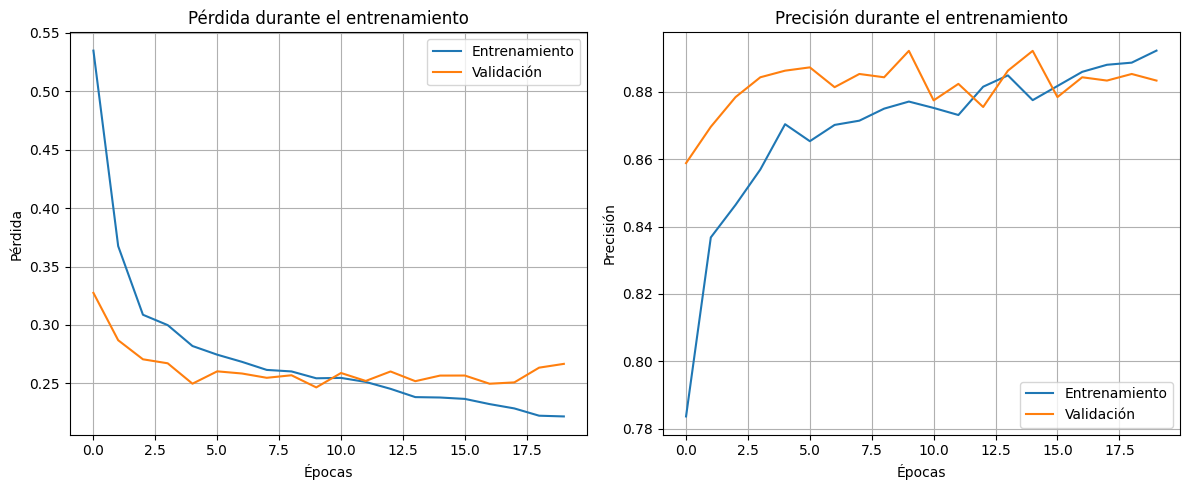

In [46]:
import matplotlib.pyplot as plt

# --- Pérdida ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# --- Precisión ---
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       527
           1       0.88      0.83      0.85       493

    accuracy                           0.86      1020
   macro avg       0.86      0.86      0.86      1020
weighted avg       0.86      0.86      0.86      1020



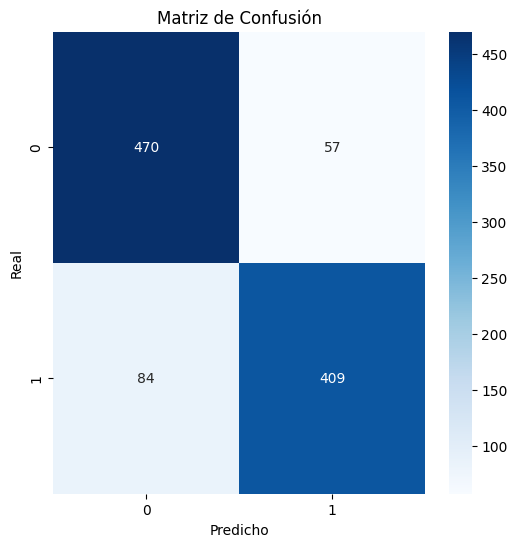

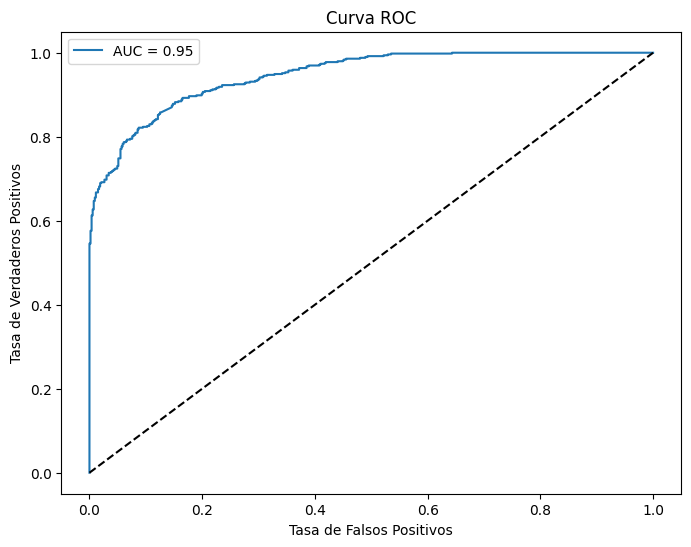

In [47]:
from sklearn.metrics import roc_curve  # Añade esta importación
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predicciones en el conjunto de test
y_pred = model.predict(X_test).ravel()
y_pred_classes = (y_pred > 0.5).astype("int32")

# Reporte de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [48]:
def ingresar_y_clasificar_noticia():
    print("📰 Analizando noticia de ejemplo...\n")

    noticia = {
    'titulo': ['Expulsan a una joven de 16 años de un instituto en Cataluña por hablar español… ¡en una clase de lengua española!'],
    'autor': ['alertadigital'],
    'fecha': ['05-04-2019'],
    'contenido': ["""
Expulsan a una joven de 16 años de un instituto en Cataluña por hablar español… ¡en una clase de lengua española!

Una madre ha denunciado ante el Defensor del Pueblo catalán «Sindic de Greuges» la expulsión de su hija de 16 años de un centro de enseñanzas medias de la provincia de Barcelona por hablar en español.

Según afirma la madre de la joven expulsada, la clase era de español; aún así, la profesora la estaba impartiendo en catalán y exigió a los alumnos que hablaran en esa lengua. La respuesta de la estudiante fue rotunda: “No voy a hablar en catalán porque estamos en clase de español”.

La reacción de la dirección del centro no se hizo esperar: la joven de 16 años ha sido expulsada hasta después de Semana Santa.

Los hechos, que se produjeron ayer jueves 4 de abril, prueba, en opinión de la denunciante, la persecución ideológica en los centros educativos catalanes.

“No se puede consentir que porque nuestra lengua no sea la catalana, nos miren y nos traten como gentuza y ni siquiera quieran atendernos”, denuncia la madre de la alumna expulsada. Y añade: “No podemos permitir que en el siglo XXI te impongan el idioma que debes hablar, cuando el idioma más hablado en Cataluña, mal que le pese, es el español”.
    """]
}






    df_noticia = pd.DataFrame(noticia)
    print("\n🔍 Procesando la noticia...")

    try:
        # --- Cargar transformadores ---
        import joblib
        scaler = joblib.load('scaler_metadata.pkl')
        scaler_bert = joblib.load('scaler_bert.pkl')
        scaler_heuristic = joblib.load('scaler_heuristic.pkl')
        ohe = joblib.load('encoder_autor.pkl')

        # --- Heurísticas ---
        X_heuristico = generar_embedding_heuristico(df_noticia.copy(), df_diccionario)
        X_heuristico = scaler_heuristic.transform(X_heuristico)

        # --- Metadata ---
        df_meta, _ = feature_engineering(df_noticia.copy())

        # Escalar solo las columnas numéricas
        col_num = ['longitud', 'longitud_titulo', 'exclamaciones', 'interrogaciones',
                   'palabras_sensacionalistas', 'noticias_autor', 'relacion_titulo_contenido']
        X_num = df_meta[col_num].values
        X_num_scaled = scaler.transform(X_num)

        # Variables cíclicas
        X_ciclicas = df_meta[['mes_sin', 'mes_cos', 'dia_sin', 'dia_cos']].values

        # Autor (OHE)
        X_autor = ohe.transform(df_meta[['autor']])

        # Concatenar metadata
        X_metadata = np.concatenate([X_num_scaled, X_ciclicas, X_autor], axis=1)

        # --- BERT ---
        df_noticia['contenido_limpio'] = df_noticia['contenido'].apply(limpiar_texto)
        inputs = tokenizer(
            df_noticia['contenido_limpio'].iloc[0],
            return_tensors='pt',
            truncation=True,
            padding=True,
            max_length=512
        )
        with torch.no_grad():
            outputs = model_bert(**inputs)
            X_bert = outputs.last_hidden_state[:, 0, :].squeeze().numpy().reshape(1, -1)
        X_bert = scaler_bert.transform(X_bert)

        # --- Concatenar todo ---
        X_final = np.concatenate([X_bert, X_metadata, X_heuristico], axis=1)

        # --- Asegurar dimensiones compatibles ---
        required_dim = model.input_shape[1]
        if X_final.shape[1] < required_dim:
            padding = np.zeros((1, required_dim - X_final.shape[1]))
            X_final = np.concatenate([X_final, padding], axis=1)
        elif X_final.shape[1] > required_dim:
            X_final = X_final[:, :required_dim]

        # --- Predicción ---
        probabilidad = float(model.predict(X_final, verbose=0)[0][0])
        clasificacion = "Verdadera" if probabilidad >= 0.5 else "Falsa"

        # --- Mostrar resultados ---
        print("\n📊 Resultados:")
        print(f"- Probabilidad de ser verdadera: {probabilidad:.2%}")
        print(f"- Clasificación: {clasificacion}")

        # --- Explicación heurística ---
        print("\n🔎 Factores considerados:")
        titulo = df_noticia['titulo'].iloc[0]
        contenido = df_noticia['contenido'].iloc[0]
        autor = df_noticia['autor'].iloc[0]

        coincidencias = len(
            set(limpiar_texto(titulo).split()).intersection(
                set(limpiar_texto(contenido).split())
            )
        )
        print(f"- Coincidencias título-contenido: {coincidencias} palabras clave")

        if autor.lower() == "desconocido":
            print("- ⚠️ Autor desconocido (reduce credibilidad)")

        longitud = len(contenido.split())
        if longitud < 150:
            print(f"- Contenido corto ({longitud} palabras)")
        elif longitud > 800:
            print(f"- Contenido muy largo ({longitud} palabras)")
        else:
            print(f"- Longitud adecuada ({longitud} palabras)")

        exclamaciones = contenido.count('!')
        if exclamaciones > 3:
            print(f"- ⚠️ {exclamaciones} signos de exclamación (posible sensacionalismo)")

        dic_emocional = construir_diccionario_emocional(df_diccionario)
        emotividad = calcular_emotividad(contenido, dic_emocional)
        emocion = emocion_predominante(contenido, dic_emocional)
        print(f"- Score de emotividad: {emotividad:.2f} (emoción predominante: {emocion})")

    except Exception as e:
        print(f"\n❌ Error al procesar la noticia: {str(e)}")
        print("Por favor verifica los datos ingresados e intenta nuevamente.")


In [64]:
ingresar_y_clasificar_noticia()

📰 Analizando noticia de ejemplo...


🔍 Procesando la noticia...

📊 Resultados:
- Probabilidad de ser verdadera: 19.70%
- Clasificación: Falsa

🔎 Factores considerados:
- Coincidencias título-contenido: 18 palabras clave
- Longitud adecuada (218 palabras)
- Score de emotividad: 0.11 (emoción predominante: positivo)


In [62]:
import joblib
import pandas as pd
import numpy as np
import torch
from transformers import DistilBertTokenizer, DistilBertModel

def guardar_modelo_y_recursos(modelo, scaler_metadata, scaler_bert, scaler_heuristic, 
                             ohe_autor, tokenizer, model_bert, df_diccionario,
                             funciones_auxiliares):
    """
    Guarda todos los recursos necesarios para hacer predicciones futuras
    
    Parámetros:
    modelo: Modelo Keras entrenado
    scaler_metadata: Scaler para características de metadata
    scaler_bert: Scaler para embeddings BERT
    scaler_heuristic: Scaler para características heurísticas
    ohe_autor: OneHotEncoder para autores
    tokenizer: Tokenizer de DistilBERT
    model_bert: Modelo DistilBERT
    df_diccionario: DataFrame con el diccionario emocional
    funciones_auxiliares: Diccionario con funciones críticas
    """
    # Guardar modelo Keras
    modelo.save('modelo_final.keras')
    
    # Guardar escaladores y transformadores
    joblib.dump(scaler_metadata, 'scaler_metadata.pkl')
    joblib.dump(scaler_bert, 'scaler_bert.pkl')
    joblib.dump(scaler_heuristic, 'scaler_heuristic.pkl')
    joblib.dump(ohe_autor, 'ohe_autor.pkl')
    
    # Guardar modelo y tokenizer de BERT
    tokenizer.save_pretrained('bert_tokenizer')
    model_bert.save_pretrained('bert_model')
    
    # Guardar diccionario emocional
    df_diccionario.to_csv('diccionario.csv', index=False)
    
    # Guardar funciones auxiliares
    joblib.dump(funciones_auxiliares, 'funciones_auxiliares.pkl')
    
    print("✅ Todos los recursos guardados exitosamente")

# Ejemplo de uso (al final del entrenamiento):
funciones_aux = {
    'limpiar_texto': limpiar_texto,
    'construir_diccionario_emocional': construir_diccionario_emocional,
    'calcular_emotividad': calcular_emotividad,
    'emocion_predominante': emocion_predominante,
    'feature_engineering': feature_engineering
}

guardar_modelo_y_recursos(
    modelo=model,
    scaler_metadata=scaler,
    scaler_bert=scaler_bert,
    scaler_heuristic=scaler_heuristic,
    ohe_autor=ohe,
    tokenizer=tokenizer,
    model_bert=model_bert,
    df_diccionario=df_diccionario,
    funciones_auxiliares=funciones_aux
)

✅ Todos los recursos guardados exitosamente
